### Попробуем здесь адаптировать новые формулы факторизации для модели Б-Ш, чтобы сравнить их впоследствии с имеющимися.

In [1]:
import numpy as np
from numpy import log, sqrt, exp, fft, array, pi
import matplotlib.pyplot as plt

Параметры контракта down-and-out put

In [2]:
# model parameters - we are going to evaluate a barrier put
T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

In [3]:
# Определим функцию выплат:
def G(y, barrier, strike):
    """payoff_function for a given option type (down-and-out put there)"""
    if (barrier <= y) and (y <= strike):
        return K_original - H_original*exp(y)
    else:
        return 0

Характеристическая экспонента процесса Б-Ш
$$\psi(\xi) = \frac{{\color{green}{\sigma}}^2}{2} \xi^2 - i{\color{green}{\gamma}}\xi$$

In [4]:
sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

Подготавливаем дискретизацию, задаём шкалу по переменной, связанной с ценой, производим замены
$$ y = ln(S)$$
$$ K = ln(K), H = ln(H) $$

Укладываем $M$ точек между $L \cdot ln(1/2)$  и $ L \cdot ln(2) $

При этом заметим, что наши  действия с разбиением не будут безобидными - природа функций, интегралы от которых мы будем брать, требует мелкой сетки и по переменной $\xi$ (частот), и по $y$ (или $x$) - (цен), а по переменной часот - ещё и довольно значительного (пока) разлёта.

Схема преобразований Фурье будет переносить нас по сеткам в следующем порядке.

1. $y \rightarrow \xi$ - FT для вычисления оператора
2. $\xi \rightarrow y$ - iFT для вычисления 1-го слагаемого приближённого символа
3. $y \rightarrow \xi$ - FT для вычисления 2-го слагаемого приближённого символа
4. $\xi \rightarrow y$ - FT из оператора обратно

Учитывая, что мы используем один и тот же вид FT, вид пространства после переноса определяется только количеством точек и шагом и известен с самого начала.

In [5]:
M = 2**16

# потому что dy нужно править много где, пока запомним, что dy = dx
dx = 0.001

x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)
u_space = np.linspace(-pi/dx, pi/dx, num = M, endpoint = False)
du = u_space[1] - u_space[0]

print("В вычислениях будет использовано всего", M, "точек")
print("du = ", du)
print("Частота меняется от ", -pi/dx, "до", pi/dx)

print("dx = ", dx)
print("Пространственная переменная меняется от ", x_space[0], "до", x_space[M-1])

print("Отношение длин диапазонов пространство/частота:", (x_space[M-1] -  x_space[0])/(2*pi/dx))
print("Отношение длин диапазонов частота/пространство:", (2*pi/dx)/(x_space[M-1] -  x_space[0]))

L = 1  # scaling coefficient
y_min = L * log(0.5)
y_max = L * log(2.0)

K = log(K_original/H_original)
H = log(H_original/H_original)
y_space = x_space # prices array

print('L =', L)
print("Диапазон пространства в лог. шкале в терминах L был бы от ", y_min, 'до', y_max)

В вычислениях будет использовано всего 65536 точек
du =  0.0958737992428
Частота меняется от  -3141.592653589793 до 3141.592653589793
dx =  0.001
Пространственная переменная меняется от  -32.768 до 32.767
Отношение длин диапазонов пространство/частота: 0.0104302191955
Отношение длин диапазонов частота/пространство: 95.8752621833
L = 1
Диапазон пространства в лог. шкале в терминах L был бы от  -0.69314718056 до 0.69314718056


In [6]:

# plt.plot(y_space, color = 'y')
# plt.ylabel('price line in logscale')
# plt.show()

Теперь дискретизация по времени:

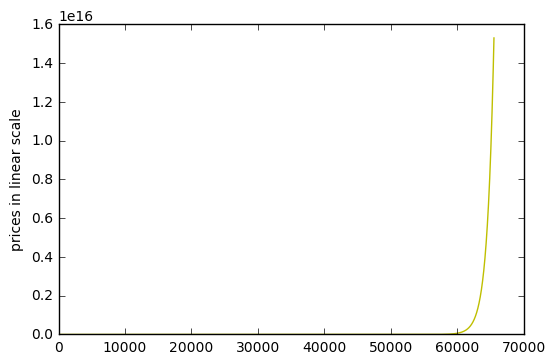

In [7]:
original_prices_array = H_original * exp(y_space)
# time discretization
N = 20  # number_of_time_steps
delta_t = T/N

plt.plot(original_prices_array, color = 'y')
plt.ylabel('prices in linear scale')
plt.show()

Величины, связанные с факторизацией. В этой модели всё просто - при постоянной вариации нет необходимости учитывать эффекты решётки вариации.

Действие, которое мы хотим произвести на каждом шаге по времени, выглядит так:
$$f_n(y) = ({\color{green}{q\Delta t}}) ^{-1} \mathcal{E}_{\color{green}{q}}^- 1_{y>ln(H)} \mathcal{E}_{\color{green}{q}}^+ f_{n+1}(y)$$

Получить хотим $f_0(y)$, там для каждого y и ответ лежит

Зелёные - константы. Определим их.

In [8]:
q = 1.0/delta_t + r
print('q = ', q)
factor = (q*delta_t)**(-1)
print('Множитель каждого шага =', factor)

# Зададим начальные уловия
f_N = array([G(y_element, H, K) for y_element in y_space]) # = g(x) i.e. payoff func

# plt.plot(original_prices_array, f_N,  'y')
# plt.ylabel('initial conditions, payoff func')
# plt.xlabel('stock price', color = 'y')
# plt.show()

q =  20.0953101798
Множитель каждого шага = 0.995257093374


В уравнении выше есть нигде пока не определённные функции (на самом деле, операторы)
$$ \mathcal{E}^\pm_q f(x) = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \hat{f}(\xi) d\xi $$


А в них - пока не определённые $\phi_q^\pm$

Подробно процедуры для их вычисления описаны с сопутствующими соображениями в блокноте Mex-BS new mex symbol comparison. Здесь же составим краткие версии процедур. Сперва нужное нам потом везде преобразование Фурье, определённое "как надо"

In [9]:
def make_rad_fft(f_x, d):
    '''
    Вычисляет преобразование Фурье без двух "пи" в показателе экспоненты
    
    Параметры:
    
    f_x - массив значений функции, задаваемый "как есть", без особенностей хранения
    и определённый на диапазоне [-M*dx/2, M*dx/2] в M = 2**N равноудалённых точках, без последней.
    
    d = dx - желаемый шаг по переменной x
    
    Области определения:
    
    xi_space = np.linspace( -pi/dx, pi/dx, num = M, endpoint = False)
    x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)
    '''
    dx = d
    M = len(f_x)
    
    sign_change_k = np.array([(-1)**k for k in range(0, M)])
    sign_change_l = np.array([(-1)**l for l in range(0, M)])
    #учитываем порядок хранения
    sign_change_l = fft.fftshift(sign_change_l)

    f = sign_change_k * f_x
    f_hat = dx * sign_change_l * fft.fft(f)
    
    # избегаем особенностей хранения результатов fft, нам они не нужны.
    return f_hat

def make_rad_ifft(f_hat_xi, d):
    '''
    Вычисляет обратное преобразование Фурье без двух "пи" в показателе экспоненты
    
    Параметры:
    
    f_xi - массив значений функции, задаваемый "как есть", без особенностей хранения
    и определённый на диапазоне [-pi/d, pi/d] в M = 2**N равноудалённых точках, без последней.
    
    d = dx - желаемый шаг по переменной x, после того, как ifft отработает
    
    Области определения:
    
    xi_space = np.linspace( -pi/dx, pi/dx, num = M, endpoint = False)
    x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)

    '''
    dx = d
    M = len(f_hat_xi)

    sign_change_k = np.array([(-1)**k for k in range(0, M)])
    sign_change_l = np.array([(-1)**l for l in range(0, M)])

    f =  (1/(dx)) * sign_change_k * fft.ifft(sign_change_l * f_hat_xi)
    return f

## Фи-минус

$\phi^-_q(\xi)$ будут иметь вид:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta =$$
$$= 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) =  $$
$$= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$
$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

In [10]:
omega_plus = 1

def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной в степень двойки, исходя из логики дальнейшего использования
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

def F_minus_capital():
    indicator = np.where(x_space >= 0, 1, 0)
    trimmed_x_space = indicator*x_space # чтобы при "сильно отрицательных" x не росла экспонента
    integral = make_rad_ifft(integrand_minus(u_space), dx)
    exponent = exp(-trimmed_x_space * omega_plus)
    return indicator * exponent * integral 

fm = F_minus_capital()

F_m_hat = make_rad_fft(fm, dx)

def make_phi_minus_array(xi_array):
    first_term = - 1j * xi_array * (fm[M//2])
    second_term = - xi_array * xi_array * F_m_hat
    return exp(first_term + second_term)

mex_symbol_minus = make_phi_minus_array(u_space)

## Фи-плюс

$\phi^+_q(\xi)$ будут иметь вид:

$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)], $$
$$ F^+(x) = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty + i\omega_-}^{+\infty + i\omega_-} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta = $$
$$ = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_-)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon) = $$ 
$$ = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon);$$
$$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx. $$

$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)] $$

In [13]:
omega_minus = -1

def integrand_plus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_minus)) / (upsilon + 1j*omega_minus)**2 for upsilon in upsilon_array])

def F_plus_capital():
    indicator = np.where(x_space <= 0, 1, 0)
    trimmed_x_space = indicator*x_space # чтобы при "сильно положительных" x не росла экспонента
    integral = make_rad_ifft(integrand_plus(u_space), dx)
    exponent = exp(-trimmed_x_space * omega_minus)
    return indicator * exponent * integral 

fp = F_plus_capital()
F_p_hat = make_rad_fft(fp, dx)

def make_phi_plus_array(xi_array):
    first_term = 1j *  xi_array * fp[M//2]
    second_term = - xi_array * xi_array * F_p_hat
    return exp(first_term + second_term)

mex_symbol_plus = make_phi_plus_array(u_space)

Теперь появляется возможность перейти к итеративной процедуре. В контексте модели Б-Ш она довольно проста.

На входе каждого из шагов есть $ \color{cyan}{f_n(y)} $


$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} \color{blue}{\mathcal{E}^-_q} \mathcal{1}_{0,+\infty}(y) \color{orange}{\mathcal{E}^+_q}\color{cyan}{f_n(y)}.$$


Принимая во внимание, что 

$$ \mathcal{E}^\pm_q (\color{cyan}{f(y)}) = (2\pi)^{-  1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^\pm_q (\xi) \color{magenta}{\hat{f}(\xi)} d\xi,$$

можно раскрыть выражение выше в виде (черту стоит понимать как преобразование Фурье):

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^-_q (\xi) (
\overline{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^+_q (\xi) \color{red}{\hat{f}(\xi)} d\xi})}d\xi}
$$

Перед тем, как продолжить, стоит сказать ещё несколько слов о том, как эта конструкция может выглядеть в виде алгоритма. Внешняя простота интегралов выше обманчива.

Прямое преобразование Фурье мы определяем как:

$$ \color{magenta}{\hat{f}(\xi)} = \int_{-\infty}^{+\infty} e^{-ix\xi} \color{cyan}{f(x)} dx $$

Обратное преобразование Фурье - в виде

$$ \color{cyan}{f(x)} = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \color{magenta}{\hat{f}(\xi)} dx $$

Мы раньше записали операторы следующим образом: 

$$ \mathcal{E}^\pm_q (\color{cyan}{f(x)}) = (2\pi)^{-  1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \color{magenta}{\hat{f}(\xi)} d\xi$$

Полностью же это можно записать так:

$$ \mathcal{E}^\pm_q (\color{cyan}{f(x)}) = (2\pi)^{-  1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \color{magenta}{(\int_{-\infty}^{+\infty} e^{-ix\xi} \color{cyan}{f(x)} dx)} d\xi,$$

Далее, рассмотрим ближе конструкцию из итеративной процедуры:

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} \color{blue}{\mathcal{E}^-_q} \mathcal{1}_{0,+\infty}(y) \color{orange}{\mathcal{E}^+_q}\color{cyan}{f_n(y)}.$$

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^-_q (\xi) (
\overline
{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{ix\xi} 
\phi^+_q (\xi) 
\color{magenta}{\hat{f}(\xi)} 
d\xi})
}
d\xi}
$$

Запишем внутренности $\color{orange}{\mathcal{E}^+_q}(\color{cyan}{f(y)})$

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^-_q (\xi) (
\overline
{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{
(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{iy\xi} 
\phi^+_q (\xi) 
(\color{magenta}{\int_{-\infty}^{+\infty} e^{-iy\xi} \color{cyan}{f_n(y)} dy})
d\xi})
}
d\xi}
$$

Нужно теперь отразить тот факт, что от выражения

$$
\overline
{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{
(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{iy\xi} 
\phi^+_q (\xi) 
(\color{magenta}{\int_{-\infty}^{+\infty} e^{-iy\xi} \color{cyan}{f_n(y)} dy})
d\xi})
}
$$

(которое и является функцией-аргументом для оператора $\color{blue}{\mathcal{E}^-_q}$) придётся взять преобразование Фурье.

Получится вот что

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^-_q (\xi) (
\color{red}
{
\int_{-\infty}^{+\infty} e^{-iy\xi}(
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{
(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{iy\xi} 
\phi^+_q (\xi) 
(\color{magenta}{\int_{-\infty}^{+\infty} e^{-iy\xi} \color{cyan}{f_n(y)} dy})
d\xi})
dy
}
)d\xi}
$$

Вычисление придётся проводить в средующем порядке.

0. Подготовить массив значений функции $\color{cyan}{f_n(y)}$
1. <span style="color:magenta">Вычислить от него преобразование Фурье</span>
2. Результат будет определён в точках $\xi$. В тех же точках нужно определить $\color{orange}{\phi^+_q (\xi)}$, после чего выполнить поэлементное умножение массивов.
3. <span style="color:orange">От того, что получилось - вычислить обратное преобразование Фурье</span>
4. Теперь результат будет определён в точках $y$ снова. В этих же точках нужно определить индикатор, в виде массива, после чего выполнить поэлементное умножение результата шага 3 на массив-индикатор
5. <span style="color:red">От того, что получилось - вычислить прямое преобразование Фурье</span>
6. Результат будет определён в точках $\xi$. В тех же точках нужно определить $\color{blue}{\phi^-_q (\xi)}$, после чего выполнить поэлементное умножение массивов.
7. <span style="color:blue">От того, что получилось - вычислить обратное преобразование Фурье</span>
8. <span style="color:green">Полученный результат умножить на константу.</span>
9. Результат, который мы получили, нужно положить в массив, который называется $\color{cyan}{f_{n+1}(y)}$

Все шаги повторить до тех пор, пока $n\ne N$. Найдя $\color{cyan}{f_{N}(y)}$ нужно провести интерполяцию и получить необходимые ответы.

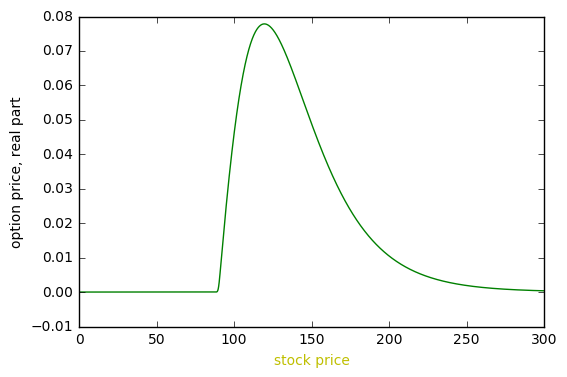

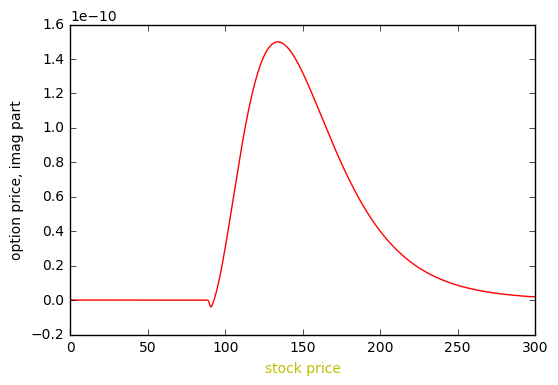

In [14]:
phi_minus_array = make_phi_minus_array(u_space)
phi_plus_array = make_phi_plus_array(u_space)

#to cut the strange effects on high prices out
trimmer = np.where(original_prices_array < 2.5*K_original, 1.0, 0.0)

#indicator-function, for the y-domain
indicator = np.where(y_space > 0, 1.0, 0.0)

# main cycle (iterating over time)
f_n = array(f_N)

for i in range(N):
   f_n_plus_1 = factor * make_rad_ifft(phi_minus_array *
       make_rad_fft(indicator * 
               make_rad_ifft(phi_plus_array * make_rad_fft(f_n, dx), dx), dx), dx)
   f_n = f_n_plus_1 #* trimmer

plt.plot(original_prices_array[(original_prices_array > 0) & (original_prices_array < 300)], 
         f_n_plus_1.real[(original_prices_array > 0) & (original_prices_array < 300)], 'g')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, real part')
filename_real_pic = "out_bsmex_l_re N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_real_pic)
plt.show()

plt.plot(original_prices_array[(original_prices_array > 0) & (original_prices_array < 300)], 
         f_n_plus_1.imag[(original_prices_array > 0) & (original_prices_array < 300)], 'r')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, imag part')
filename_imag_pic = "out_bsmex_l_im N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_imag_pic)
plt.show()

32517
34127


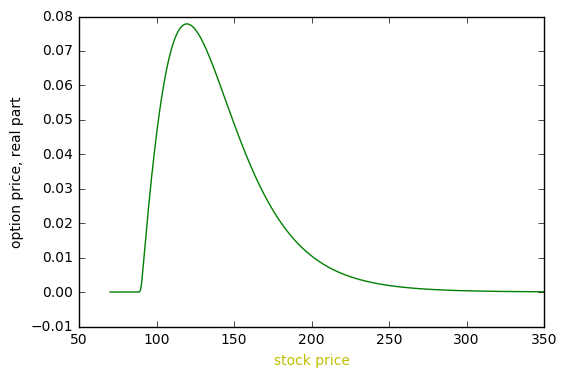

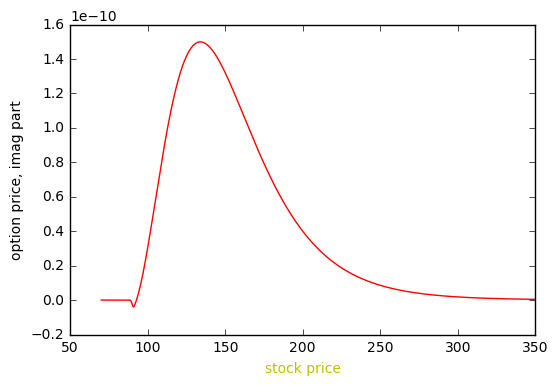

In [15]:
index_bot = 0
while(original_prices_array[index_bot] < H_original-20):
    index_bot+=1
print(index_bot)

index_top = 0
while(original_prices_array[index_top] < 350):
    index_top+=1
print(index_top)

plt.plot(original_prices_array[index_bot:index_top], f_n_plus_1.real[index_bot:index_top], 'g')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, real part')
filename_real_pic = "out_bsmex_s_re N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_real_pic)
plt.show()

plt.plot(original_prices_array[index_bot:index_top], f_n_plus_1.imag[index_bot:index_top], 'r')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, imag part')
filename_imag_pic = "out_bsmex_s_im N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_imag_pic)
plt.savefig("out.png")
plt.show()